In [1]:
import functools
import sys

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers

In [2]:
seed = 0

torch.manual_seed(seed)

In [3]:
train_data, test_data = datasets.load_dataset('imdb', split=['train', 'test'])

Reusing dataset imdb (/home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


In [4]:
transformer_name = 'bert-base-uncased'

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)

In [5]:
tokenizer.tokenize('hello world!')

['hello', 'world', '!']

In [6]:
tokenizer.encode('hello world!')

[101, 7592, 2088, 999, 102]

In [7]:
tokenizer.convert_ids_to_tokens(tokenizer.encode('hello world'))

['[CLS]', 'hello', 'world', '[SEP]']

In [8]:
tokenizer('hello world!')

{'input_ids': [101, 7592, 2088, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [9]:
def tokenize_and_numericalize_data(example, tokenizer):
    ids = tokenizer(example['text'], truncation=True)['input_ids']
    return {'ids': ids}

In [10]:
train_data = train_data.map(tokenize_and_numericalize_data, fn_kwargs={'tokenizer': tokenizer})
test_data = test_data.map(tokenize_and_numericalize_data, fn_kwargs={'tokenizer': tokenizer})

Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-2d2ddeb0d544c918.arrow
Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-1c96c2577c929948.arrow


In [11]:
train_data[0]

{'label': 1,
 'text': 'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!',
 'ids': [101,
  22953,
  2213,
  4381,
  2152,
  2003,
  1037,
  9476,
  4038,
  1012,
  2009,
  2743,
  2012,
  1996,
  2168,
  2051,
  2004,
  2070,
  2060,
  345

In [12]:
tokenizer.vocab['!']

999

In [13]:
tokenizer.pad_token

'[PAD]'

In [14]:
tokenizer.pad_token_id

0

In [15]:
tokenizer.vocab[tokenizer.pad_token]

0

In [16]:
pad_index = tokenizer.pad_token_id

In [17]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data['train']
valid_data = train_valid_data['test']

Loading cached split indices for dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-0b46d41b3a9a5f87.arrow and /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-83b98d9279b85695.arrow


In [18]:
train_data = train_data.with_format(type='torch', columns=['ids', 'label'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'label'])
test_data = test_data.with_format(type='torch', columns=['ids', 'label'])

In [19]:
transformer = transformers.AutoModel.from_pretrained(transformer_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
transformer.config.hidden_size

768

In [21]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False
        
    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:,0,:]
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction

In [22]:
output_dim = len(train_data['label'].unique())
freeze = False

model = Transformer(transformer, output_dim, freeze)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 109,483,778 trainable parameters


In [24]:
lr = 1e-5

optimizer = optim.Adam(model.parameters(), lr=lr)

In [25]:
criterion = nn.CrossEntropyLoss()

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
model = model.to(device)
criterion = criterion.to(device)

In [28]:
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'label': batch_label}
    return batch

In [29]:
batch_size = 8

collate = functools.partial(collate, pad_index=pad_index)

train_dataloader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=batch_size, 
                                               collate_fn=collate, 
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

In [30]:
def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(dataloader, desc='training...', file=sys.stdout):
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [31]:
def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(dataloader, desc='evaluating...', file=sys.stdout):
            ids = batch['ids'].to(device)
            label = batch['label'].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [32]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [33]:
n_epochs = 3
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)
    
    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'transformer.pt')
    
    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

evaluating...: 100%|██████████| 782/782 [00:40<00:00, 19.24it/s]
epoch: 1
train_loss: 0.249, train_acc: 0.894
valid_loss: 0.196, valid_acc: 0.925
evaluating...: 100%|██████████| 782/782 [00:40<00:00, 19.26it/s]
epoch: 2
train_loss: 0.135, train_acc: 0.950
valid_loss: 0.202, valid_acc: 0.927
evaluating...: 100%|██████████| 782/782 [00:40<00:00, 19.25it/s]
epoch: 3
train_loss: 0.067, train_acc: 0.978
valid_loss: 0.249, valid_acc: 0.929


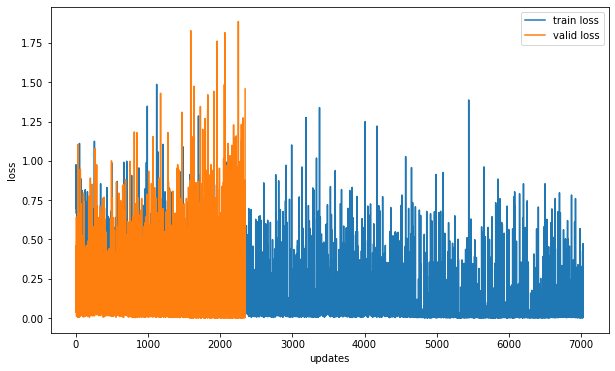

In [34]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss');

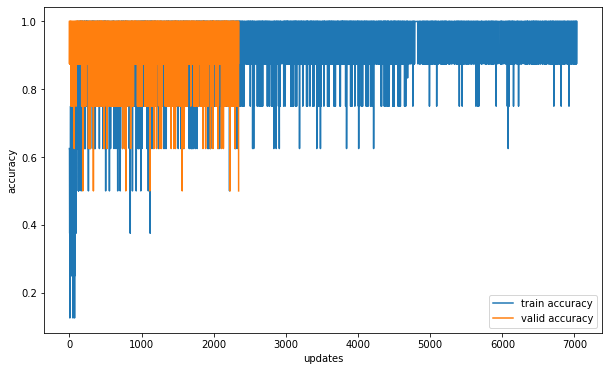

In [35]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

In [36]:
model.load_state_dict(torch.load('transformer.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

evaluating...: 100%|██████████| 3125/3125 [02:45<00:00, 18.89it/s]
test_loss: 0.178, test_acc: 0.932


In [37]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)['input_ids']
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [38]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, device)

(0, 0.9898680448532104)

In [39]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, device)

(1, 0.9934925436973572)

In [40]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, device)

(1, 0.99724280834198)

In [41]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, device)

(0, 0.9856145977973938)